In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestRegressor
import subprocess
from sklearn.model_selection import RandomizedSearchCV
import sys
import math
import scipy.spatial.distance
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.tree import DecisionTreeRegressor
import os
import shutil
import glob
import shap
from scipy.stats import pearsonr

cmap='viridis'
sys.path.insert(1, '../')
from LibHelperFuncs import *

from iterative_spectral_method.src import *
from iterative_spectral_method.sdr import *

rstate = 3123
np.random.seed(3123)
njob = 20
global_trees = 100

plt.rcParams['axes.grid'] = False

C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-

In [2]:
originalDat = np.genfromtxt("../../Data/data_bas_preprocessing.csv", delimiter=',')
originalDat_pd = pd.read_csv("../../Data/data_bas_preprocessing_pd.csv")

X = originalDat[:,:-1]
Y = originalDat[:,-1]
C = originalDat_pd.columns

lower_thres = 1e-3

files = []
objectives = ['ISM_gaus_homogeneous_0.5.csv', 'pca_sparse_homogeneous_0.5.csv',\
              "ISM_squa_homogeneous_0.5.csv", "ISM_poly_homogeneous_0.5.csv",\
              'pca_standard.csv', 'nmf_H_matrix_homogeneous_0.5.csv', 'pca_homogeneous_0.5.csv']

In [4]:
def compute_carried_shap(s_vals, comps, X):
    shap_values_r = np.arange(0, X.shape[0]).reshape(-1, 1)
    carried_shap_vals = np.apply_along_axis((lambda x : s_vals[x].reshape(-1, 1).T @ comps), 1, shap_values_r).reshape(-1, X.shape[1])
    return carried_shap_vals

def mean_carried_shap(s_vals, comps, X):
    
    sump = np.sqrt(np.mean(comps ** 2, axis=0))
    sump[np.where(sump == 0)[0]] = 1
    sump = sump ** 2
    sump[np.where(sump < 1e-8)[0]] = 1
    
    t = compute_carried_shap(s_vals, comps, X) / sump
    return np.mean(np.abs(t), axis=0) 

In [5]:
rf = LinearRegression()
rf.fit(X, Y)

exp = shap.LinearExplainer(rf, X)
s_vals = exp.shap_values(X)
ov_shap = np.mean(np.abs(s_vals), axis=0)

In [6]:
pca = PCA(n_components=50)
pca.fit(X)
comps = pca.components_
X_r = (comps @ X.T).T

rf = LinearRegression()
rf.fit(X_r, Y)

exp = shap.LinearExplainer(rf, X_r)
s_vals = exp.shap_values(X_r)
ov_reduced_shap = mean_carried_shap(s_vals, pca.components_, X)

In [14]:
ltscores = []

renge = range(1, 120)
tsets = np.arange(0.5, 1, 0.1)

for t in tsets:
    l2scores = []

    for k in renge:
        X_r = X[:,np.argsort(ov_reduced_shap)[::-1][:k]]
        
        rf = LinearRegression()
        
        rf.fit(X_r, Y)
        l2scores.append(model_eval(X_r, Y, rf, tsize=t, rstate=rstate))
    
    ltscores.append(l2scores)

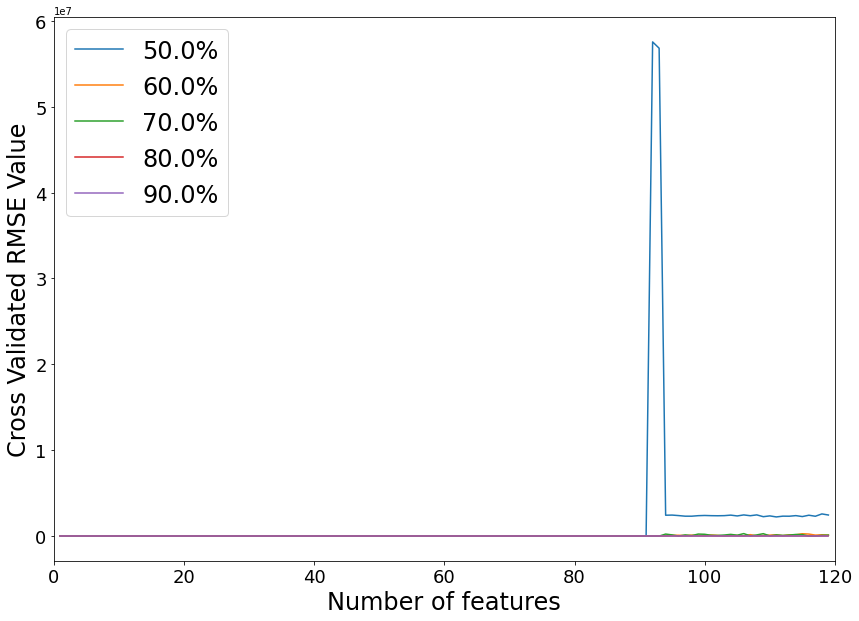

In [15]:
plt.figure(figsize=(14,10))

plt.xlim([0, 120])

for x in range(0, tsets.shape[0]):
    plt.plot(renge, ltscores[x], label='{}%'.format(round(tsets[x], 2) * 100))
    
plt.xlabel('Number of features', fontsize=24)
plt.ylabel("Cross Validated RMSE Value", fontsize=24)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)